# PAKDD 2014 - ASUS Malfunctional Components Prediction

## Table Of Contents
- [Description](#Description)
- [Evaluation](#Evaluation)

### Description 

** Goal ** - Predict future malfunctional components of ASUS notebooks from historical data. This will help estimate how many products require maintenance. Information is provided related to shipments and laptops requiring maintenance and repair. Using this information we have to estimate how many of each module of specific model will require repair.

### Evaluation

$$MAE = \frac{1}{n}\sum_{i=1}^{n}| y_i - \hat{y_i} |$$

In [51]:
# display inline plots
%matplotlib inline

# import libraries for numerical and scientific computing
import numpy as np
import scipy as sp

# import matplotlib for plotting
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# import pandas for data wrangling and munging
import pandas as pd

# set some options for better view
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# import plotting library built on top of matplotlib
import seaborn as sns

# set some settings related to style of plots that will render
sns.set_style("whitegrid")
sns.set_context("poster")

import warnings
warnings.filterwarnings('ignore')

In [72]:
# load sales and repair log
sales = pd.read_csv('./data/SaleTrain.csv')
repair = pd.read_csv('./data/RepairTrain.csv')

In [73]:
# output id mapping
output_id_map = pd.read_csv('./data/Output_TargetID_Mapping.csv')

In [74]:
sales.head(3)

,module_category,component_category,year/month,number_sale
0,M4,P27,2005/1,0
1,M4,P27,2005/5,1042
2,M4,P27,2005/9,1677


** Data about Sale of various modules and components of laptops starting from January, 2005 to February, 2008 **

In [75]:
repair.head(3)

,module_category,component_category,year/month(sale),year/month(repair),number_repair
0,M6,P16,2007/9,2009/4,1
1,M2,P30,2007/9,2009/8,1
2,M1,P12,2006/10,2008/2,2


** Data about Repair and Maintenance for various models and components of laptops starting from February, 2005 to December, 2009 **

In [76]:
output_id_map.head(3)

,module_category,component_category,year,month
0,M1,P02,2010,1
1,M1,P02,2010,2
2,M1,P02,2010,3


** Predict number of repair for each of module and component combination mentioned in above dataframe for the time-period January, 2010 to July, 2011 **

### Pairs of Module and Component 

In [77]:
def get_all_pairs(sales):
    pairs = []
    for module, component in zip(sales['module_category'], sales['component_category']):
        if (module, component) not in pairs:
            pairs.append((module, component))
    return pairs

In [78]:
pairs_sales = get_all_pairs(sales)

In [79]:
min_module_category = sorted(pairs, key=lambda x: int(x[0][1]))[0][0]
max_module_category = sorted(pairs, key=lambda x: int(x[0][1]), reverse=True)[0][0]

min_component_category = sorted(pairs, key=lambda x: int(x[1][1:]))[0][1]
max_component_category = sorted(pairs, key=lambda x: int(x[1][1:]), reverse=True)[0][1]

In [80]:
print 'Min Module category %s, Max Module Category %s ' %(min_module_category, max_module_category)
print 'Min Component category %s, Max Component category %s ' %(min_component_category, max_component_category)

Min Module category M1, Max Module Category M9 
Min Component category P01, Max Component category P31 


** The minimum module category is M0, maximum module category is M9 and minimum component category is P01 and maximum component category is P31 **

### Modules and Components in test set

In [81]:
pairs_repairs = get_all_pairs(repair)

In [82]:
print 'Number of pairs in sales', len(pairs_sales)
print 'Number of pairs in repair', len(pairs_repairs)

Number of pairs in sales 310
Number of pairs in repair 224


In [83]:
pairs_test = get_all_pairs(output_id_map)

In [84]:
print 'Module and Component pairs not in test set \n\n', list(set(pairs_sales) - set(pairs_test))

Module and Component pairs not in test set 

[('M0', 'P21'), ('M1', 'P18'), ('M4', 'P18'), ('M5', 'P07'), ('M0', 'P18'), ('M2', 'P03'), ('M0', 'P15'), ('M7', 'P18'), ('M0', 'P22'), ('M4', 'P03'), ('M6', 'P07'), ('M9', 'P18'), ('M0', 'P05'), ('M7', 'P08'), ('M0', 'P28'), ('M1', 'P29'), ('M5', 'P14'), ('M1', 'P03'), ('M2', 'P23'), ('M9', 'P07'), ('M0', 'P25'), ('M6', 'P14'), ('M5', 'P08'), ('M3', 'P29'), ('M7', 'P14'), ('M0', 'P26'), ('M7', 'P23'), ('M6', 'P29'), ('M1', 'P23'), ('M1', 'P14'), ('M4', 'P07'), ('M5', 'P29'), ('M9', 'P14'), ('M0', 'P01'), ('M8', 'P08'), ('M3', 'P14'), ('M0', 'P14'), ('M0', 'P31'), ('M0', 'P23'), ('M5', 'P23'), ('M0', 'P06'), ('M9', 'P03'), ('M0', 'P29'), ('M0', 'P17'), ('M6', 'P18'), ('M4', 'P23'), ('M7', 'P29'), ('M6', 'P23'), ('M5', 'P18'), ('M3', 'P07'), ('M0', 'P08'), ('M3', 'P08'), ('M8', 'P07'), ('M9', 'P29'), ('M1', 'P08'), ('M5', 'P25'), ('M0', 'P10'), ('M0', 'P27'), ('M4', 'P29'), ('M6', 'P08'), ('M8', 'P23'), ('M8', 'P18'), ('M0', 'P02'), ('M7', 'P

In [85]:
not_in_test_set = list(set(pairs_sales) - set(pairs_test))

## Renaming columns

In [86]:
import re

In [87]:
def rename_columns(column):
    column = re.sub(r'[/()]', '_', column)
    return column

sales.columns = sales.columns.map(rename_columns)
repair.columns = repair.columns.map(rename_columns)
output_id_map.columns = output_id_map.columns.map(rename_columns)

In [88]:
output_id_map.head(3)

,module_category,component_category,year,month
0,M1,P02,2010,1
1,M1,P02,2010,2
2,M1,P02,2010,3


In [89]:
sales['year_month'] = pd.to_datetime(sales.year_month)

repair['year_month_sale_'] = pd.to_datetime(repair.year_month_sale_)
repair['year_month_repair_'] = pd.to_datetime(repair.year_month_repair_)

In [94]:
sales.groupby('module_category').mean()

,number_sale
module_category,
M0,1028.891228
M1,779.456410
M2,1817.800000
M3,658.159722
M4,575.150671
M5,489.635407
M6,2508.972222
M7,505.397163
M8,623.700560


In [109]:
m0 = sales[sales.module_category == 'M2'][['year_month', 'number_sale']]

In [110]:
m0 = m0.set_index('year_month')

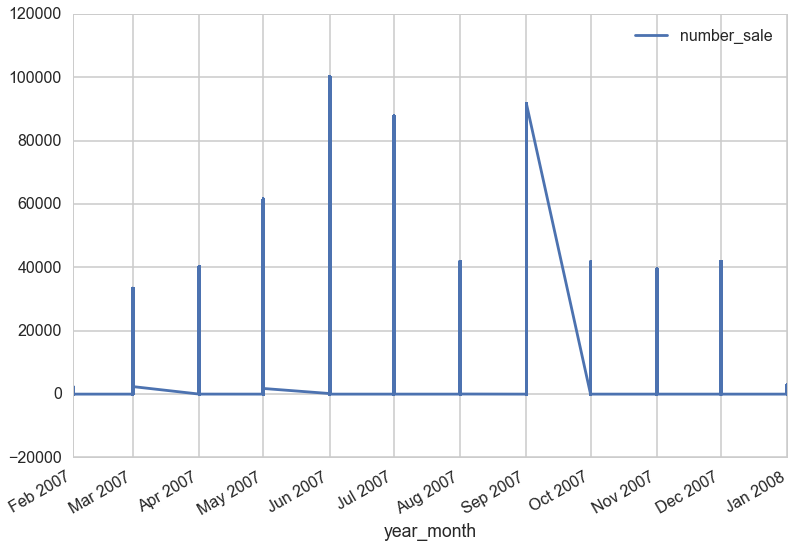

In [111]:
m0.plot();

In [118]:
c = sales.groupby(['module_category', 'year_month'])['number_sale']

In [125]:
g = c.mean().unstack(0).fillna(0)

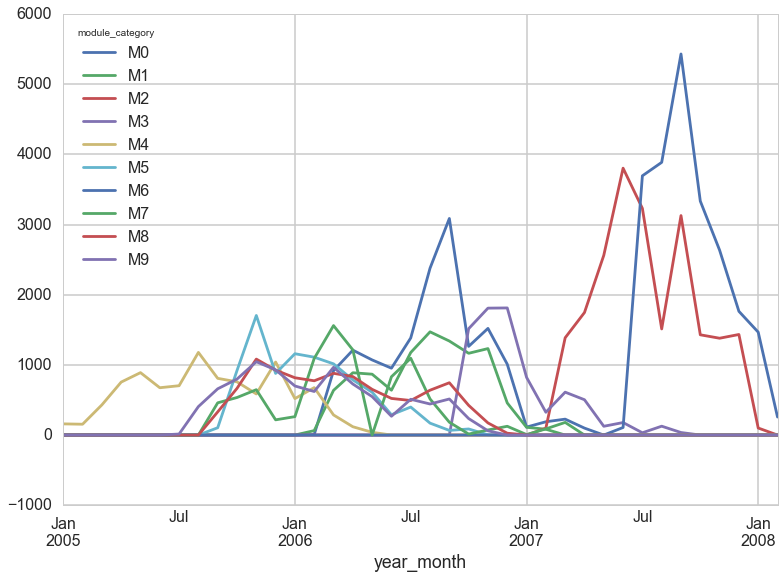

In [127]:
g.plot();

In [129]:
sales[sales.module_category == 'M9']['number_sale'].mean()

555.5200534759358